# Depression Transformer Chatbot

In [32]:
import tensorflow as tf
tf.random.set_seed(1234)
import tensorflow_datasets as tfds

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
path_to_dataset = os.path.join(os.getcwd(), "Dataset")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

In [3]:
#Load and preprocess data
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  return sentence


def load_conversations():
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
  return inputs, outputs


questions, answers = load_conversations()

In [4]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: i really , really , really wanna go , but i can t . not unless my sister goes .
Sample answer: i m workin on it . but she doesn t seem to be goin for him .


In [5]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [6]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 312, 2, 312, 2, 152, 412, 186, 2, 43, 4, 39, 8006, 3, 36, 915, 30, 1478, 3314, 1]


In [7]:
# Maximum sentence length
MAX_LENGTH = 40


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [8]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8148
Number of samples: 194413


### Create `tf.data.Dataset`

We are going to use the [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((questions,answers))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
print(dataset.take(1))

<TakeDataset shapes: ((None, 40), (None, 40)), types: (tf.int32, tf.int32)>


### Masking



In [11]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [12]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


## Transformer

###Multi Head Attention



In [13]:
def scaled_dot_product_attention(q, k, v, mask):


    matmul_qk = tf.matmul(q, k, transpose_b=True)  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 

    output = tf.matmul(attention_weights, v)  

    return output, attention_weights

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):

        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size) 
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size) 


        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  

        output = self.dense(concat_attention)  

        return output, attention_weights

### Positional encoding


In [15]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


### Encoder



In [16]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'), 
      tf.keras.layers.Dense(d_model)  
    ])

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  

        ffn_output = self.ffn(out1)  
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  

        return out2

In [18]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  


TensorShape([64, 43, 512])

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  


In [20]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape) 

(64, 62, 512)


### Decoder

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  

        ffn_output = self.ffn(out2)  
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  

        return out3, attn_weights_block1, attn_weights_block2

In [22]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape 

TensorShape([64, 50, 512])

In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2


        return x, attention_weights

In [24]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.tokenizer(inp, training, enc_padding_mask)  
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  

        return final_output, attention_weights

In [26]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape 

TensorShape([64, 36, 8000])

## Train model

### Initialize model



In [27]:
tf.keras.backend.clear_session()

# Hyper-parameters
num_layers = 2
d_model = 256
num_heads = 8
dff = 512
dropout_rate = 0.1

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE, 
    pe_input=1000, 
    pe_target=1000,
    rate=dropout_rate)


In [28]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

### Loss function



In [29]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
     

Text(0.5, 0, 'Train Step')

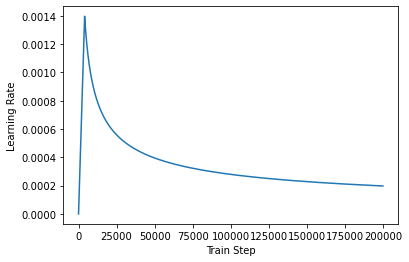

In [33]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Compile Model


In [34]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')


### Fit model

Train our transformer by simply calling `model.fit()`

In [37]:
EPOCHS = 50

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy(tar_real, predictions))


In [38]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')


Epoch 1 Batch 0 Loss 2.4655 Accuracy 0.0256
Epoch 1 Batch 50 Loss 2.4689 Accuracy 0.0256
Epoch 1 Batch 100 Loss 2.3649 Accuracy 0.0256
Epoch 1 Batch 150 Loss 2.2451 Accuracy 0.0266
Epoch 1 Batch 200 Loss 2.1734 Accuracy 0.0303
Epoch 1 Batch 250 Loss 2.1164 Accuracy 0.0336
Epoch 1 Batch 300 Loss 2.0760 Accuracy 0.0370
Epoch 1 Batch 350 Loss 2.0323 Accuracy 0.0404
Epoch 1 Batch 400 Loss 1.9939 Accuracy 0.0437
Epoch 1 Batch 450 Loss 1.9637 Accuracy 0.0467
Epoch 1 Batch 500 Loss 1.9323 Accuracy 0.0490
Epoch 1 Batch 550 Loss 1.9063 Accuracy 0.0512
Epoch 1 Batch 600 Loss 1.8847 Accuracy 0.0532
Epoch 1 Batch 650 Loss 1.8598 Accuracy 0.0549
Epoch 1 Batch 700 Loss 1.8397 Accuracy 0.0563
Epoch 1 Batch 750 Loss 1.8252 Accuracy 0.0577
Epoch 1 Batch 800 Loss 1.8082 Accuracy 0.0589
Epoch 1 Batch 850 Loss 1.7923 Accuracy 0.0601
Epoch 1 Batch 900 Loss 1.7777 Accuracy 0.0611
Epoch 1 Batch 950 Loss 1.7643 Accuracy 0.0621
Epoch 1 Batch 1000 Loss 1.7525 Accuracy 0.0630
Epoch 1 Batch 1050 Loss 1.7399 Accur

Epoch 3 Batch 2550 Loss 1.2667 Accuracy 0.0972
Epoch 3 Batch 2600 Loss 1.2667 Accuracy 0.0972
Epoch 3 Batch 2650 Loss 1.2670 Accuracy 0.0972
Epoch 3 Batch 2700 Loss 1.2671 Accuracy 0.0972
Epoch 3 Batch 2750 Loss 1.2674 Accuracy 0.0973
Epoch 3 Batch 2800 Loss 1.2681 Accuracy 0.0973
Epoch 3 Batch 2850 Loss 1.2677 Accuracy 0.0974
Epoch 3 Batch 2900 Loss 1.2674 Accuracy 0.0974
Epoch 3 Batch 2950 Loss 1.2674 Accuracy 0.0974
Epoch 3 Batch 3000 Loss 1.2677 Accuracy 0.0974
Epoch 3 Loss 1.2679 Accuracy 0.0975
Time taken for 1 epoch: 183.95 secs

Epoch 4 Batch 0 Loss 1.2114 Accuracy 0.1046
Epoch 4 Batch 50 Loss 1.2469 Accuracy 0.0984
Epoch 4 Batch 100 Loss 1.2337 Accuracy 0.0988
Epoch 4 Batch 150 Loss 1.2380 Accuracy 0.0985
Epoch 4 Batch 200 Loss 1.2341 Accuracy 0.0987
Epoch 4 Batch 250 Loss 1.2288 Accuracy 0.0991
Epoch 4 Batch 300 Loss 1.2244 Accuracy 0.0993
Epoch 4 Batch 350 Loss 1.2270 Accuracy 0.0995
Epoch 4 Batch 400 Loss 1.2277 Accuracy 0.0997
Epoch 4 Batch 450 Loss 1.2288 Accuracy 0.0998


Epoch 6 Batch 1900 Loss 1.1879 Accuracy 0.1037
Epoch 6 Batch 1950 Loss 1.1875 Accuracy 0.1037
Epoch 6 Batch 2000 Loss 1.1871 Accuracy 0.1036
Epoch 6 Batch 2050 Loss 1.1867 Accuracy 0.1036
Epoch 6 Batch 2100 Loss 1.1859 Accuracy 0.1036
Epoch 6 Batch 2150 Loss 1.1855 Accuracy 0.1035
Epoch 6 Batch 2200 Loss 1.1863 Accuracy 0.1036
Epoch 6 Batch 2250 Loss 1.1868 Accuracy 0.1036
Epoch 6 Batch 2300 Loss 1.1867 Accuracy 0.1036
Epoch 6 Batch 2350 Loss 1.1869 Accuracy 0.1036
Epoch 6 Batch 2400 Loss 1.1867 Accuracy 0.1036
Epoch 6 Batch 2450 Loss 1.1872 Accuracy 0.1036
Epoch 6 Batch 2500 Loss 1.1878 Accuracy 0.1036
Epoch 6 Batch 2550 Loss 1.1880 Accuracy 0.1036
Epoch 6 Batch 2600 Loss 1.1881 Accuracy 0.1037
Epoch 6 Batch 2650 Loss 1.1883 Accuracy 0.1037
Epoch 6 Batch 2700 Loss 1.1883 Accuracy 0.1037
Epoch 6 Batch 2750 Loss 1.1887 Accuracy 0.1037
Epoch 6 Batch 2800 Loss 1.1895 Accuracy 0.1038
Epoch 6 Batch 2850 Loss 1.1900 Accuracy 0.1038
Epoch 6 Batch 2900 Loss 1.1904 Accuracy 0.1038
Epoch 6 Batch

Epoch 9 Batch 1350 Loss 1.1521 Accuracy 0.1074
Epoch 9 Batch 1400 Loss 1.1518 Accuracy 0.1075
Epoch 9 Batch 1450 Loss 1.1516 Accuracy 0.1075
Epoch 9 Batch 1500 Loss 1.1513 Accuracy 0.1075
Epoch 9 Batch 1550 Loss 1.1516 Accuracy 0.1074
Epoch 9 Batch 1600 Loss 1.1510 Accuracy 0.1074
Epoch 9 Batch 1650 Loss 1.1500 Accuracy 0.1074
Epoch 9 Batch 1700 Loss 1.1509 Accuracy 0.1074
Epoch 9 Batch 1750 Loss 1.1506 Accuracy 0.1074
Epoch 9 Batch 1800 Loss 1.1504 Accuracy 0.1074
Epoch 9 Batch 1850 Loss 1.1506 Accuracy 0.1073
Epoch 9 Batch 1900 Loss 1.1500 Accuracy 0.1072
Epoch 9 Batch 1950 Loss 1.1496 Accuracy 0.1071
Epoch 9 Batch 2000 Loss 1.1495 Accuracy 0.1071
Epoch 9 Batch 2050 Loss 1.1488 Accuracy 0.1070
Epoch 9 Batch 2100 Loss 1.1485 Accuracy 0.1070
Epoch 9 Batch 2150 Loss 1.1490 Accuracy 0.1070
Epoch 9 Batch 2200 Loss 1.1501 Accuracy 0.1070
Epoch 9 Batch 2250 Loss 1.1510 Accuracy 0.1070
Epoch 9 Batch 2300 Loss 1.1511 Accuracy 0.1071
Epoch 9 Batch 2350 Loss 1.1519 Accuracy 0.1071
Epoch 9 Batch

Epoch 12 Batch 550 Loss 1.1282 Accuracy 0.1096
Epoch 12 Batch 600 Loss 1.1302 Accuracy 0.1096
Epoch 12 Batch 650 Loss 1.1308 Accuracy 0.1098
Epoch 12 Batch 700 Loss 1.1287 Accuracy 0.1097
Epoch 12 Batch 750 Loss 1.1285 Accuracy 0.1096
Epoch 12 Batch 800 Loss 1.1300 Accuracy 0.1096
Epoch 12 Batch 850 Loss 1.1316 Accuracy 0.1097
Epoch 12 Batch 900 Loss 1.1325 Accuracy 0.1098
Epoch 12 Batch 950 Loss 1.1306 Accuracy 0.1097
Epoch 12 Batch 1000 Loss 1.1327 Accuracy 0.1098
Epoch 12 Batch 1050 Loss 1.1330 Accuracy 0.1098
Epoch 12 Batch 1100 Loss 1.1332 Accuracy 0.1098
Epoch 12 Batch 1150 Loss 1.1326 Accuracy 0.1098
Epoch 12 Batch 1200 Loss 1.1336 Accuracy 0.1099
Epoch 12 Batch 1250 Loss 1.1323 Accuracy 0.1098
Epoch 12 Batch 1300 Loss 1.1305 Accuracy 0.1097
Epoch 12 Batch 1350 Loss 1.1294 Accuracy 0.1097
Epoch 12 Batch 1400 Loss 1.1288 Accuracy 0.1097
Epoch 12 Batch 1450 Loss 1.1289 Accuracy 0.1097
Epoch 12 Batch 1500 Loss 1.1285 Accuracy 0.1096
Epoch 12 Batch 1550 Loss 1.1275 Accuracy 0.1096
E

Epoch 14 Batch 2900 Loss 1.1222 Accuracy 0.1107
Epoch 14 Batch 2950 Loss 1.1229 Accuracy 0.1107
Epoch 14 Batch 3000 Loss 1.1231 Accuracy 0.1107
Epoch 14 Loss 1.1231 Accuracy 0.1107
Time taken for 1 epoch: 179.61 secs

Epoch 15 Batch 0 Loss 0.9642 Accuracy 0.1066
Epoch 15 Batch 50 Loss 1.1455 Accuracy 0.1120
Epoch 15 Batch 100 Loss 1.1247 Accuracy 0.1115
Epoch 15 Batch 150 Loss 1.1220 Accuracy 0.1119
Epoch 15 Batch 200 Loss 1.1236 Accuracy 0.1121
Epoch 15 Batch 250 Loss 1.1191 Accuracy 0.1118
Epoch 15 Batch 300 Loss 1.1131 Accuracy 0.1117
Epoch 15 Batch 350 Loss 1.1110 Accuracy 0.1115
Epoch 15 Batch 400 Loss 1.1091 Accuracy 0.1116
Epoch 15 Batch 450 Loss 1.1070 Accuracy 0.1115
Epoch 15 Batch 500 Loss 1.1082 Accuracy 0.1115
Epoch 15 Batch 550 Loss 1.1099 Accuracy 0.1116
Epoch 15 Batch 600 Loss 1.1119 Accuracy 0.1116
Epoch 15 Batch 650 Loss 1.1109 Accuracy 0.1115
Epoch 15 Batch 700 Loss 1.1119 Accuracy 0.1115
Epoch 15 Batch 750 Loss 1.1122 Accuracy 0.1114
Epoch 15 Batch 800 Loss 1.1146 Ac

Epoch 17 Batch 2100 Loss 1.1046 Accuracy 0.1120
Epoch 17 Batch 2150 Loss 1.1049 Accuracy 0.1120
Epoch 17 Batch 2200 Loss 1.1055 Accuracy 0.1120
Epoch 17 Batch 2250 Loss 1.1061 Accuracy 0.1120
Epoch 17 Batch 2300 Loss 1.1058 Accuracy 0.1120
Epoch 17 Batch 2350 Loss 1.1066 Accuracy 0.1120
Epoch 17 Batch 2400 Loss 1.1071 Accuracy 0.1120
Epoch 17 Batch 2450 Loss 1.1077 Accuracy 0.1121
Epoch 17 Batch 2500 Loss 1.1078 Accuracy 0.1121
Epoch 17 Batch 2550 Loss 1.1078 Accuracy 0.1121
Epoch 17 Batch 2600 Loss 1.1079 Accuracy 0.1120
Epoch 17 Batch 2650 Loss 1.1079 Accuracy 0.1120
Epoch 17 Batch 2700 Loss 1.1081 Accuracy 0.1121
Epoch 17 Batch 2750 Loss 1.1084 Accuracy 0.1121
Epoch 17 Batch 2800 Loss 1.1088 Accuracy 0.1121
Epoch 17 Batch 2850 Loss 1.1088 Accuracy 0.1121
Epoch 17 Batch 2900 Loss 1.1090 Accuracy 0.1121
Epoch 17 Batch 2950 Loss 1.1093 Accuracy 0.1121
Epoch 17 Batch 3000 Loss 1.1097 Accuracy 0.1122
Epoch 17 Loss 1.1098 Accuracy 0.1122
Time taken for 1 epoch: 179.52 secs

Epoch 18 Batch

Epoch 20 Batch 1350 Loss 1.0952 Accuracy 0.1138
Epoch 20 Batch 1400 Loss 1.0957 Accuracy 0.1138
Epoch 20 Batch 1450 Loss 1.0955 Accuracy 0.1138
Epoch 20 Batch 1500 Loss 1.0956 Accuracy 0.1138
Epoch 20 Batch 1550 Loss 1.0959 Accuracy 0.1138
Epoch 20 Batch 1600 Loss 1.0954 Accuracy 0.1137
Epoch 20 Batch 1650 Loss 1.0949 Accuracy 0.1137
Epoch 20 Batch 1700 Loss 1.0946 Accuracy 0.1136
Epoch 20 Batch 1750 Loss 1.0947 Accuracy 0.1137
Epoch 20 Batch 1800 Loss 1.0951 Accuracy 0.1136
Epoch 20 Batch 1850 Loss 1.0961 Accuracy 0.1135
Epoch 20 Batch 1900 Loss 1.0962 Accuracy 0.1135
Epoch 20 Batch 1950 Loss 1.0959 Accuracy 0.1134
Epoch 20 Batch 2000 Loss 1.0947 Accuracy 0.1132
Epoch 20 Batch 2050 Loss 1.0938 Accuracy 0.1132
Epoch 20 Batch 2100 Loss 1.0936 Accuracy 0.1131
Epoch 20 Batch 2150 Loss 1.0938 Accuracy 0.1131
Epoch 20 Batch 2200 Loss 1.0944 Accuracy 0.1131
Epoch 20 Batch 2250 Loss 1.0949 Accuracy 0.1131
Epoch 20 Batch 2300 Loss 1.0947 Accuracy 0.1132
Epoch 20 Batch 2350 Loss 1.0952 Accuracy

Epoch 23 Batch 550 Loss 1.0859 Accuracy 0.1148
Epoch 23 Batch 600 Loss 1.0867 Accuracy 0.1149
Epoch 23 Batch 650 Loss 1.0863 Accuracy 0.1147
Epoch 23 Batch 700 Loss 1.0854 Accuracy 0.1147
Epoch 23 Batch 750 Loss 1.0860 Accuracy 0.1147
Epoch 23 Batch 800 Loss 1.0878 Accuracy 0.1147
Epoch 23 Batch 850 Loss 1.0878 Accuracy 0.1148
Epoch 23 Batch 900 Loss 1.0884 Accuracy 0.1148
Epoch 23 Batch 950 Loss 1.0883 Accuracy 0.1148
Epoch 23 Batch 1000 Loss 1.0884 Accuracy 0.1148
Epoch 23 Batch 1050 Loss 1.0889 Accuracy 0.1148
Epoch 23 Batch 1100 Loss 1.0900 Accuracy 0.1148
Epoch 23 Batch 1150 Loss 1.0905 Accuracy 0.1149
Epoch 23 Batch 1200 Loss 1.0891 Accuracy 0.1148
Epoch 23 Batch 1250 Loss 1.0874 Accuracy 0.1148
Epoch 23 Batch 1300 Loss 1.0862 Accuracy 0.1147
Epoch 23 Batch 1350 Loss 1.0850 Accuracy 0.1147
Epoch 23 Batch 1400 Loss 1.0853 Accuracy 0.1147
Epoch 23 Batch 1450 Loss 1.0855 Accuracy 0.1147
Epoch 23 Batch 1500 Loss 1.0851 Accuracy 0.1146
Epoch 23 Batch 1550 Loss 1.0848 Accuracy 0.1146
E

Epoch 25 Batch 2900 Loss 1.0858 Accuracy 0.1150
Epoch 25 Batch 2950 Loss 1.0856 Accuracy 0.1150
Epoch 25 Batch 3000 Loss 1.0858 Accuracy 0.1151
Saving checkpoint for epoch 25 at ./checkpoints/train/ckpt-5
Epoch 25 Loss 1.0860 Accuracy 0.1151
Time taken for 1 epoch: 183.69 secs

Epoch 26 Batch 0 Loss 0.9993 Accuracy 0.1134
Epoch 26 Batch 50 Loss 1.1066 Accuracy 0.1167
Epoch 26 Batch 100 Loss 1.1028 Accuracy 0.1165
Epoch 26 Batch 150 Loss 1.0955 Accuracy 0.1156
Epoch 26 Batch 200 Loss 1.0930 Accuracy 0.1158
Epoch 26 Batch 250 Loss 1.0867 Accuracy 0.1160
Epoch 26 Batch 300 Loss 1.0779 Accuracy 0.1157
Epoch 26 Batch 350 Loss 1.0780 Accuracy 0.1156
Epoch 26 Batch 400 Loss 1.0702 Accuracy 0.1152
Epoch 26 Batch 450 Loss 1.0730 Accuracy 0.1154
Epoch 26 Batch 500 Loss 1.0742 Accuracy 0.1154
Epoch 26 Batch 550 Loss 1.0762 Accuracy 0.1156
Epoch 26 Batch 600 Loss 1.0778 Accuracy 0.1156
Epoch 26 Batch 650 Loss 1.0790 Accuracy 0.1158
Epoch 26 Batch 700 Loss 1.0812 Accuracy 0.1160
Epoch 26 Batch 750 

Epoch 28 Batch 2100 Loss 1.0728 Accuracy 0.1157
Epoch 28 Batch 2150 Loss 1.0734 Accuracy 0.1157
Epoch 28 Batch 2200 Loss 1.0735 Accuracy 0.1157
Epoch 28 Batch 2250 Loss 1.0744 Accuracy 0.1157
Epoch 28 Batch 2300 Loss 1.0745 Accuracy 0.1157
Epoch 28 Batch 2350 Loss 1.0750 Accuracy 0.1157
Epoch 28 Batch 2400 Loss 1.0750 Accuracy 0.1157
Epoch 28 Batch 2450 Loss 1.0749 Accuracy 0.1157
Epoch 28 Batch 2500 Loss 1.0757 Accuracy 0.1157
Epoch 28 Batch 2550 Loss 1.0761 Accuracy 0.1158
Epoch 28 Batch 2600 Loss 1.0769 Accuracy 0.1159
Epoch 28 Batch 2650 Loss 1.0770 Accuracy 0.1159
Epoch 28 Batch 2700 Loss 1.0771 Accuracy 0.1159
Epoch 28 Batch 2750 Loss 1.0772 Accuracy 0.1159
Epoch 28 Batch 2800 Loss 1.0774 Accuracy 0.1159
Epoch 28 Batch 2850 Loss 1.0777 Accuracy 0.1159
Epoch 28 Batch 2900 Loss 1.0781 Accuracy 0.1159
Epoch 28 Batch 2950 Loss 1.0783 Accuracy 0.1159
Epoch 28 Batch 3000 Loss 1.0784 Accuracy 0.1159
Epoch 28 Loss 1.0792 Accuracy 0.1160
Time taken for 1 epoch: 183.71 secs

Epoch 29 Batch

Epoch 31 Batch 1300 Loss 1.0684 Accuracy 0.1174
Epoch 31 Batch 1350 Loss 1.0675 Accuracy 0.1173
Epoch 31 Batch 1400 Loss 1.0672 Accuracy 0.1173
Epoch 31 Batch 1450 Loss 1.0678 Accuracy 0.1173
Epoch 31 Batch 1500 Loss 1.0682 Accuracy 0.1173
Epoch 31 Batch 1550 Loss 1.0685 Accuracy 0.1172
Epoch 31 Batch 1600 Loss 1.0684 Accuracy 0.1172
Epoch 31 Batch 1650 Loss 1.0682 Accuracy 0.1172
Epoch 31 Batch 1700 Loss 1.0685 Accuracy 0.1172
Epoch 31 Batch 1750 Loss 1.0690 Accuracy 0.1171
Epoch 31 Batch 1800 Loss 1.0685 Accuracy 0.1171
Epoch 31 Batch 1850 Loss 1.0683 Accuracy 0.1170
Epoch 31 Batch 1900 Loss 1.0680 Accuracy 0.1169
Epoch 31 Batch 1950 Loss 1.0684 Accuracy 0.1168
Epoch 31 Batch 2000 Loss 1.0672 Accuracy 0.1167
Epoch 31 Batch 2050 Loss 1.0665 Accuracy 0.1166
Epoch 31 Batch 2100 Loss 1.0668 Accuracy 0.1166
Epoch 31 Batch 2150 Loss 1.0664 Accuracy 0.1165
Epoch 31 Batch 2200 Loss 1.0670 Accuracy 0.1165
Epoch 31 Batch 2250 Loss 1.0679 Accuracy 0.1165
Epoch 31 Batch 2300 Loss 1.0684 Accuracy

Epoch 34 Batch 550 Loss 1.0688 Accuracy 0.1181
Epoch 34 Batch 600 Loss 1.0670 Accuracy 0.1180
Epoch 34 Batch 650 Loss 1.0671 Accuracy 0.1180
Epoch 34 Batch 700 Loss 1.0677 Accuracy 0.1180
Epoch 34 Batch 750 Loss 1.0669 Accuracy 0.1180
Epoch 34 Batch 800 Loss 1.0659 Accuracy 0.1179
Epoch 34 Batch 850 Loss 1.0662 Accuracy 0.1179
Epoch 34 Batch 900 Loss 1.0674 Accuracy 0.1180
Epoch 34 Batch 950 Loss 1.0674 Accuracy 0.1180
Epoch 34 Batch 1000 Loss 1.0667 Accuracy 0.1179
Epoch 34 Batch 1050 Loss 1.0662 Accuracy 0.1179
Epoch 34 Batch 1100 Loss 1.0654 Accuracy 0.1179
Epoch 34 Batch 1150 Loss 1.0649 Accuracy 0.1178
Epoch 34 Batch 1200 Loss 1.0650 Accuracy 0.1178
Epoch 34 Batch 1250 Loss 1.0639 Accuracy 0.1177
Epoch 34 Batch 1300 Loss 1.0629 Accuracy 0.1177
Epoch 34 Batch 1350 Loss 1.0633 Accuracy 0.1178
Epoch 34 Batch 1400 Loss 1.0636 Accuracy 0.1178
Epoch 34 Batch 1450 Loss 1.0633 Accuracy 0.1178
Epoch 34 Batch 1500 Loss 1.0631 Accuracy 0.1177
Epoch 34 Batch 1550 Loss 1.0633 Accuracy 0.1177
E

Epoch 36 Batch 2850 Loss 1.0628 Accuracy 0.1178
Epoch 36 Batch 2900 Loss 1.0633 Accuracy 0.1178
Epoch 36 Batch 2950 Loss 1.0633 Accuracy 0.1178
Epoch 36 Batch 3000 Loss 1.0635 Accuracy 0.1178
Epoch 36 Loss 1.0639 Accuracy 0.1178
Time taken for 1 epoch: 177.37 secs

Epoch 37 Batch 0 Loss 0.9889 Accuracy 0.1198
Epoch 37 Batch 50 Loss 1.0819 Accuracy 0.1208
Epoch 37 Batch 100 Loss 1.0738 Accuracy 0.1199
Epoch 37 Batch 150 Loss 1.0604 Accuracy 0.1190
Epoch 37 Batch 200 Loss 1.0545 Accuracy 0.1187
Epoch 37 Batch 250 Loss 1.0551 Accuracy 0.1185
Epoch 37 Batch 300 Loss 1.0533 Accuracy 0.1185
Epoch 37 Batch 350 Loss 1.0527 Accuracy 0.1185
Epoch 37 Batch 400 Loss 1.0535 Accuracy 0.1186
Epoch 37 Batch 450 Loss 1.0528 Accuracy 0.1186
Epoch 37 Batch 500 Loss 1.0535 Accuracy 0.1186
Epoch 37 Batch 550 Loss 1.0549 Accuracy 0.1188
Epoch 37 Batch 600 Loss 1.0558 Accuracy 0.1188
Epoch 37 Batch 650 Loss 1.0545 Accuracy 0.1187
Epoch 37 Batch 700 Loss 1.0544 Accuracy 0.1186
Epoch 37 Batch 750 Loss 1.0561 A

Epoch 39 Batch 2100 Loss 1.0532 Accuracy 0.1184
Epoch 39 Batch 2150 Loss 1.0537 Accuracy 0.1184
Epoch 39 Batch 2200 Loss 1.0544 Accuracy 0.1184
Epoch 39 Batch 2250 Loss 1.0542 Accuracy 0.1184
Epoch 39 Batch 2300 Loss 1.0542 Accuracy 0.1184
Epoch 39 Batch 2350 Loss 1.0548 Accuracy 0.1184
Epoch 39 Batch 2400 Loss 1.0553 Accuracy 0.1184
Epoch 39 Batch 2450 Loss 1.0557 Accuracy 0.1184
Epoch 39 Batch 2500 Loss 1.0564 Accuracy 0.1184
Epoch 39 Batch 2550 Loss 1.0564 Accuracy 0.1184
Epoch 39 Batch 2600 Loss 1.0566 Accuracy 0.1184
Epoch 39 Batch 2650 Loss 1.0570 Accuracy 0.1184
Epoch 39 Batch 2700 Loss 1.0571 Accuracy 0.1184
Epoch 39 Batch 2750 Loss 1.0573 Accuracy 0.1184
Epoch 39 Batch 2800 Loss 1.0578 Accuracy 0.1184
Epoch 39 Batch 2850 Loss 1.0584 Accuracy 0.1185
Epoch 39 Batch 2900 Loss 1.0584 Accuracy 0.1184
Epoch 39 Batch 2950 Loss 1.0589 Accuracy 0.1185
Epoch 39 Batch 3000 Loss 1.0589 Accuracy 0.1185
Epoch 39 Loss 1.0589 Accuracy 0.1185
Time taken for 1 epoch: 177.30 secs

Epoch 40 Batch

Epoch 42 Batch 1300 Loss 1.0513 Accuracy 0.1197
Epoch 42 Batch 1350 Loss 1.0497 Accuracy 0.1195
Epoch 42 Batch 1400 Loss 1.0488 Accuracy 0.1195
Epoch 42 Batch 1450 Loss 1.0492 Accuracy 0.1195
Epoch 42 Batch 1500 Loss 1.0496 Accuracy 0.1196
Epoch 42 Batch 1550 Loss 1.0488 Accuracy 0.1195
Epoch 42 Batch 1600 Loss 1.0481 Accuracy 0.1194
Epoch 42 Batch 1650 Loss 1.0478 Accuracy 0.1194
Epoch 42 Batch 1700 Loss 1.0477 Accuracy 0.1193
Epoch 42 Batch 1750 Loss 1.0481 Accuracy 0.1193
Epoch 42 Batch 1800 Loss 1.0472 Accuracy 0.1192
Epoch 42 Batch 1850 Loss 1.0472 Accuracy 0.1191
Epoch 42 Batch 1900 Loss 1.0474 Accuracy 0.1191
Epoch 42 Batch 1950 Loss 1.0479 Accuracy 0.1191
Epoch 42 Batch 2000 Loss 1.0476 Accuracy 0.1190
Epoch 42 Batch 2050 Loss 1.0479 Accuracy 0.1189
Epoch 42 Batch 2100 Loss 1.0476 Accuracy 0.1189
Epoch 42 Batch 2150 Loss 1.0485 Accuracy 0.1189
Epoch 42 Batch 2200 Loss 1.0494 Accuracy 0.1189
Epoch 42 Batch 2250 Loss 1.0492 Accuracy 0.1188
Epoch 42 Batch 2300 Loss 1.0494 Accuracy

Epoch 45 Batch 550 Loss 1.0452 Accuracy 0.1204
Epoch 45 Batch 600 Loss 1.0450 Accuracy 0.1205
Epoch 45 Batch 650 Loss 1.0443 Accuracy 0.1204
Epoch 45 Batch 700 Loss 1.0456 Accuracy 0.1205
Epoch 45 Batch 750 Loss 1.0468 Accuracy 0.1205
Epoch 45 Batch 800 Loss 1.0481 Accuracy 0.1204
Epoch 45 Batch 850 Loss 1.0489 Accuracy 0.1205
Epoch 45 Batch 900 Loss 1.0498 Accuracy 0.1206
Epoch 45 Batch 950 Loss 1.0504 Accuracy 0.1206
Epoch 45 Batch 1000 Loss 1.0496 Accuracy 0.1205
Epoch 45 Batch 1050 Loss 1.0495 Accuracy 0.1205
Epoch 45 Batch 1100 Loss 1.0515 Accuracy 0.1207
Epoch 45 Batch 1150 Loss 1.0508 Accuracy 0.1206
Epoch 45 Batch 1200 Loss 1.0506 Accuracy 0.1207
Epoch 45 Batch 1250 Loss 1.0494 Accuracy 0.1206
Epoch 45 Batch 1300 Loss 1.0482 Accuracy 0.1205
Epoch 45 Batch 1350 Loss 1.0473 Accuracy 0.1204
Epoch 45 Batch 1400 Loss 1.0466 Accuracy 0.1204
Epoch 45 Batch 1450 Loss 1.0463 Accuracy 0.1203
Epoch 45 Batch 1500 Loss 1.0469 Accuracy 0.1204
Epoch 45 Batch 1550 Loss 1.0464 Accuracy 0.1203
E

Epoch 47 Batch 2850 Loss 1.0454 Accuracy 0.1201
Epoch 47 Batch 2900 Loss 1.0462 Accuracy 0.1201
Epoch 47 Batch 2950 Loss 1.0467 Accuracy 0.1201
Epoch 47 Batch 3000 Loss 1.0472 Accuracy 0.1202
Epoch 47 Loss 1.0473 Accuracy 0.1202
Time taken for 1 epoch: 190.99 secs

Epoch 48 Batch 0 Loss 1.0935 Accuracy 0.1214
Epoch 48 Batch 50 Loss 1.0614 Accuracy 0.1205
Epoch 48 Batch 100 Loss 1.0576 Accuracy 0.1209
Epoch 48 Batch 150 Loss 1.0490 Accuracy 0.1210
Epoch 48 Batch 200 Loss 1.0436 Accuracy 0.1207
Epoch 48 Batch 250 Loss 1.0385 Accuracy 0.1203
Epoch 48 Batch 300 Loss 1.0364 Accuracy 0.1205
Epoch 48 Batch 350 Loss 1.0331 Accuracy 0.1203
Epoch 48 Batch 400 Loss 1.0359 Accuracy 0.1204
Epoch 48 Batch 450 Loss 1.0354 Accuracy 0.1205
Epoch 48 Batch 500 Loss 1.0370 Accuracy 0.1207
Epoch 48 Batch 550 Loss 1.0387 Accuracy 0.1209
Epoch 48 Batch 600 Loss 1.0384 Accuracy 0.1209
Epoch 48 Batch 650 Loss 1.0383 Accuracy 0.1208
Epoch 48 Batch 700 Loss 1.0400 Accuracy 0.1209
Epoch 48 Batch 750 Loss 1.0424 A

Epoch 50 Batch 2100 Loss 1.0376 Accuracy 0.1205
Epoch 50 Batch 2150 Loss 1.0378 Accuracy 0.1204
Epoch 50 Batch 2200 Loss 1.0382 Accuracy 0.1204
Epoch 50 Batch 2250 Loss 1.0389 Accuracy 0.1204
Epoch 50 Batch 2300 Loss 1.0390 Accuracy 0.1204
Epoch 50 Batch 2350 Loss 1.0392 Accuracy 0.1204
Epoch 50 Batch 2400 Loss 1.0397 Accuracy 0.1204
Epoch 50 Batch 2450 Loss 1.0401 Accuracy 0.1204
Epoch 50 Batch 2500 Loss 1.0405 Accuracy 0.1205
Epoch 50 Batch 2550 Loss 1.0408 Accuracy 0.1205
Epoch 50 Batch 2600 Loss 1.0410 Accuracy 0.1204
Epoch 50 Batch 2650 Loss 1.0413 Accuracy 0.1205
Epoch 50 Batch 2700 Loss 1.0415 Accuracy 0.1205
Epoch 50 Batch 2750 Loss 1.0418 Accuracy 0.1205
Epoch 50 Batch 2800 Loss 1.0420 Accuracy 0.1206
Epoch 50 Batch 2850 Loss 1.0420 Accuracy 0.1205
Epoch 50 Batch 2900 Loss 1.0423 Accuracy 0.1206
Epoch 50 Batch 2950 Loss 1.0429 Accuracy 0.1207
Epoch 50 Batch 3000 Loss 1.0435 Accuracy 0.1207
Saving checkpoint for epoch 50 at ./checkpoints/train/ckpt-10
Epoch 50 Loss 1.0435 Accur

## Evaluate and predict



In [39]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)
    encoder_input = sentence

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

Let's test our model!

In [40]:
output = predict('Where have you been?')

Input: Where have you been?
Output: i was going to get you out of here .


In [41]:
output = predict("It's a trap")

Input: It's a trap
Output: i know , but i m not going to let you know what i m talking about .


In [46]:
# feed the model with its previous output
sentence = 'tell me a story'
for _ in range(5):
  sentence = predict(sentence)
  print('')

Input: tell me a story
Output: i m not going to let you out .

Input: i m not going to let you out .
Output: i m not going to let you go .

Input: i m not going to let you go .
Output: i m not going to let you go .

Input: i m not going to let you go .
Output: i m not going to let you go .

Input: i m not going to let you go .
Output: i m not going to let you go .

